# 2. Analysis

In [ ]:
import torch
import torchmetrics
from tqdm import tqdm

model_names = ['resnet18',
               'resnet50',
               'resnet101',
               'resnet152',
               'resnext101_32x8d',
               'wide_resnet101_2',
               'alexnet',
               'vit_base_patch16_224',
               'beit_base_patch16_224',
               'inception_v3',
               'densenet161',
               'mobilenet_v2',
               'shufflenet_v2_x1_0',
               'densenet121',
               'densenet201',
               'googlenet',
               'vgg11',
               'vgg13',
               'vgg16',
               'vgg19'
]

aucs = torch.zeros([len(model_names), 4, 1000])
target = torch.tensor([0 if x<998 else 1 for x in range(2*998)])

for i, model_name in tqdm(enumerate(model_names)):
    acitvations = torch.load('../activations/{model_name}_wtrmrks.tnsr'.format(model_name = model_name))
    
    for j in range(4):
        for r in range(1000):
            aucs[i, j, r] = torchmetrics.functional.classification.binary_auroc(torch.cat((acitvations[:, 0, r], acitvations[:, j+1, r]), 0), target)

aucs_avg = aucs.mean(axis = 0)

In [ ]:
import pandas as pd
from utils import imagenet_to_labels

df = pd.DataFrame()

# number of classes
t = 10

# schenario
# 0 -- Chinese, 1 -- Latin, 2 -- Hindi, 3 -- Arabic numerals
k = 0

indexes = torch.argsort(aucs_avg[k], descending = True)[:t]
df['AUC ROC'] = aucs[:, k, indexes].view(-1)
df['Model'] = [model_names[i // t] for i in range(t*len(model_names))]
df['Class label'] = [str(int(indexes[i % t]))+', {name}'.format(name = imagenet_to_labels[int(indexes[i % t])].split(',')[0])  for i in range(t*len(model_names))]

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(5, 15))

if k == 0:
    name = "Chinese watermarks"
elif k == 1:
     name = "Latin watermarks"
elif k == 2:
     name = "Hindi watermarks"
elif k == 3:
     name = "Arabic numerals"

ax.set_title(name)

# Plot the orbital period with horizontal boxes
g = sns.boxplot(x="AUC ROC", y="Class label", data=df,
            width=.7, palette="vlag")

g.set(xlim=(0., 1))

# Add in points to show each observation
sns.stripplot(x="AUC ROC", y="Class label", data=df,
              size=4, color=".1", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

plt.show()

### Illustrating the contamination of the classes across different models

In [ ]:
senitivity = torch.max(aucs, 1-aucs)
sort_indeces = torch.argsort((senitivity[:, 0] > 0.7).sum(axis = 1), descending = True)

names_sorted = sorted(model_names, key=lambda x: (aucs[:, 0] > 0.6).sum(axis = 1)[model_names.index(x)], reverse = True)
senitivity_sorted = senitivity[sort_indeces, :, :]

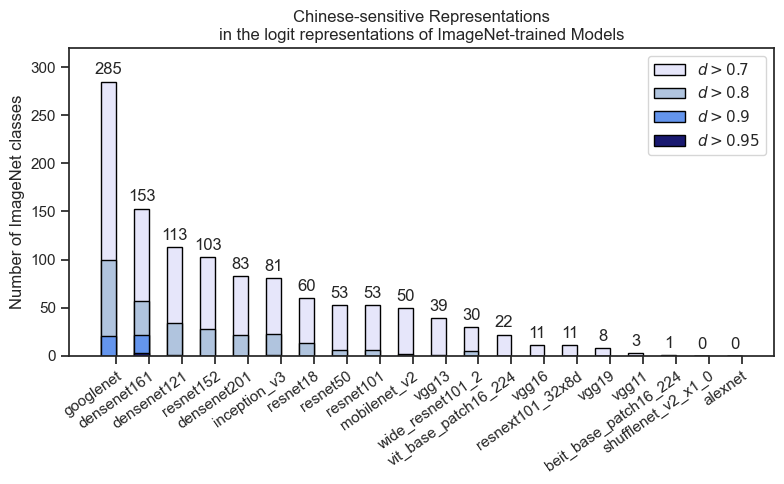

In [144]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.ticker as mtick
mpl.rcParams['font.family'] = 'Arial'

labels = names_sorted

x = np.arange(len(labels))  # the label locations
width = 0.45  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 5))
, color=(0.2, 0.4, 0.6, 0.6)

p = 2
lw = 1

#rects0 = ax.bar(x-width/p, (aucs_sorted[:, 0] > 0.6).sum(axis = 1), width, label='AUC > 0.6', color='lavender', edgecolor = 'black')
rects1 = ax.bar(x-width/p, (senitivity_sorted[:, 0] > 0.7).sum(axis = 1), width, label=r'$d > 0.7$', color='lavender', edgecolor = 'black', linewidth = lw)
rects2 = ax.bar(x-width/p, (senitivity_sorted[:, 0] > 0.8).sum(axis = 1), width, label=r'$d > 0.8$', color='lightsteelblue', edgecolor = 'black', linewidth = lw)
rects3 = ax.bar(x-width/p, (senitivity_sorted[:, 0] > 0.9).sum(axis = 1), width, label=r'$d > 0.9$', color='cornflowerblue', edgecolor = 'black', linewidth = lw)
rects4 = ax.bar(x-width/p, (senitivity_sorted[:, 0] > 0.95).sum(axis = 1), width, label=r'$d > 0.95$', color='midnightblue', edgecolor = 'black', linewidth = lw)


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Number of ImageNet classes")
ax.set_title('Chinese-sensitive Representations\nin the logit representations of ImageNet-trained Models')
ax.set_xticks(x, labels)
plt.xticks(rotation=35, ha = 'right', rotation_mode='anchor')
ax.set_ylim(0, 320)

handles, labels = plt.gca().get_legend_handles_labels()
ax.legend()

ax.bar_label(rects1, padding=3)

fig.tight_layout()
plt.show()

### Analysis of the feature extractors

In [ ]:
model_names = [ 
                'vit_base_patch16_224',
                'mobilenet_v2',
                'resnet18',
                'densenet161',
                'googlenet',
                'inception_v3',
                'shufflenet_v2_x1_0',
                'vgg11']

def get_dim(model_name):
    if model_name == 'resnet18': #512
        return 512
    elif model_name == 'alexnet': #4096
        
        return 4096
    elif model_name == 'vit_base_patch16_224': #768
        
        return 768
    elif model_name == 'beit_base_patch16_224':
       
        return 768
    elif model_name == 'inception_v3':
        
        return 2048
    elif model_name == 'densenet161':
        
        return 2208
    elif model_name == 'mobilenet_v2':
       
        return 1280
    elif model_name == 'shufflenet_v2_x1_0':
        
        return 1024
    elif model_name == 'vgg11':
        
        return 4096
    
    elif model_name == 'googlenet':
        
        return 1024

n_classes = 5
target = torch.tensor([0 if x<998 else 1 for x in range(2*998)])

aucs_all = {}
k= 0
results = torch.zeros([len(model_names), 4])

for i, model_name in tqdm(enumerate(model_names)):
    acitvations = torch.load('/Users/kirillbykov/Documents/Work/watermarks_imagenet/data/activations_features/{model_name}_features_wtrmrks.tnsr'.format(model_name = model_name))
    aucs = torch.zeros([4, get_dim(model_name)])
    n = get_dim(model_name)
    
    for j in range(4):
        for r in range(n):
            aucs[j, r] = torchmetrics.functional.classification.binary_auroc(torch.cat((acitvations[:, 0, r], acitvations[:, j+1, r]), 0), target)
            
    aucs_all[model_name] = aucs
    sensitivity = torch.max(aucs, 1-aucs)
    results[i, 0] = (sensitivity[k]>0.7).sum()/(aucs[0]>-1).sum()
    results[i, 1] = (sensitivity[k]>0.8).sum()/(aucs[0]>-1).sum()
    results[i, 2] = (sensitivity[k]>0.9).sum()/(aucs[0]>-1).sum()
    results[i, 3] = (sensitivity[k]>0.95).sum()/(aucs[0]>-1).sum()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.ticker as mtick
mpl.rcParams['font.family'] = 'Arial'

labels = model_names
res_0 = results[:, 0]*100
res_1 = results[:, 1]*100
res_2 = results[:, 2]*100
res_3 = results[:, 3]*100

x = np.arange(len(labels))  # the label locations
width = 0.55  # the width of the bars

fig, ax = plt.subplots(figsize=(5, 4.825))
, color=(0.2, 0.4, 0.6, 0.6)
lw = 1
rects1 = ax.bar(x - width/2, res_0, width, label=r'$d > 0.7$', color='lavender', edgecolor = 'black', linewidth = lw)
rects2 = ax.bar(x - width/2, res_1, width, label=r'$d > 0.8$', color='lightsteelblue', edgecolor = 'black', linewidth = lw)
rects3 = ax.bar(x - width/2, res_2, width, label=r'$d > 0.9$', color='cornflowerblue', edgecolor = 'black', linewidth = lw)
rects3 = ax.bar(x - width/2, res_3, width, label=r'$d > 0.95$', color='midnightblue', edgecolor = 'black', linewidth = lw)



# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Ratio of the of watermark-detectors, %")
ax.set_title('Proportion of Chinese-Sensitive Representations\nin the Feature Extractor Layers of ImageNet-Trained Models')
ax.set_xticks(x, labels)
plt.xticks(rotation=35, ha = 'right')
ax.legend()

ax.yaxis.set_major_formatter(mtick.PercentFormatter())

fig.tight_layout()
plt.tight_layout()

plt.show()